In [1]:
cd /home/shubham/code/genAI/genaiProject/Rerender_A_Video

/home/shubham/code/genAI/genaiProject/Rerender_A_Video


In [2]:
import mediapy as mp

In [3]:
import os
import shutil
from enum import Enum

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from blendmodes.blend import BlendType, blendLayers
from PIL import Image
from pytorch_lightning import seed_everything
from safetensors.torch import load_file
from skimage import exposure

import src.import_util  # noqa: F401
from deps.ControlNet.annotator.canny import CannyDetector
from deps.ControlNet.annotator.hed import HEDdetector
from deps.ControlNet.annotator.util import HWC3
from deps.ControlNet.cldm.model import create_model, load_state_dict
from deps.gmflow.gmflow.gmflow import GMFlow
from flow.flow_utils import get_warped_and_mask
from sd_model_cfg import model_dict
from src.config import RerenderConfig
from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.freeu import freeu_forward
from src.img_util import find_flat_region, numpy2tensor
from src.video_util import (frame_to_video, get_fps, get_frame_count,
                            prepare_frames)

inversed_model_dict = dict()
for k, v in model_dict.items():
    inversed_model_dict[v] = k

to_tensor = T.PILToTensor()
blur = T.GaussianBlur(kernel_size=(9, 9), sigma=(18, 18))


class ProcessingState(Enum):
    NULL = 0
    FIRST_IMG = 1
    KEY_IMGS = 2

class GlobalState:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(GlobalState, cls).__new__(cls)
        return cls._instance

    def __init__(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        self.detector_type = None
        self.detector = None
        self.controller = None
        self.processing_state = ProcessingState.NULL
        
        # Initialize GMFlow with DataParallel
        flow_model = GMFlow(
            feature_channels=128,
            num_scales=1,
            upsample_factor=8,
            num_head=1,
            attention_type='swin',
            ffn_dim_expansion=4,
            num_transformer_layers=6,
        ).to('cuda')
        
        checkpoint = torch.load('models/gmflow_sintel-0c07dcb3.pth',
                                map_location=lambda storage, loc: storage)
        weights = checkpoint['model'] if 'model' in checkpoint else checkpoint
        flow_model.load_state_dict(weights, strict=False)
        flow_model.eval()

        # Wrap GMFlow with DataParallel
        self.flow_model = flow_model.to('cuda:0')

        def __repr__(self):
            return (f"GlobalState("
                    f"sd_model={self.sd_model}, "
                    f"ddim_v_sampler={self.ddim_v_sampler}, "
                    f"detector_type={self.detector_type}, "
                    f"detector={self.detector}, "
                    f"controller={self.controller}, "
                    f"processing_state={self.processing_state})")

    def update_controller(self, inner_strength, mask_period, cross_period,
                          ada_period, warp_period, loose_cfattn):
        self.controller = AttentionControl(inner_strength,
                                           mask_period,
                                           cross_period,
                                           ada_period,
                                           warp_period,
                                           loose_cfatnn=loose_cfattn)

    def update_sd_model(self, sd_model, control_type, freeu_args):
        if sd_model == self.sd_model:
            return
        self.sd_model = sd_model

        # Load ControlNet model
        model = create_model('./deps/ControlNet/models/cldm_v15.yaml').to('cpu')
        if control_type == 'HED':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_hed.pth',
                                location='cuda:2'))
        elif control_type == 'canny':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_canny.pth',
                                location='cuda:2'))

        model = model.cuda()
        
        # Load Stable Diffusion model
        sd_model_path = model_dict[sd_model]
        if len(sd_model_path) > 0:
            model_ext = os.path.splitext(sd_model_path)[1]
            if model_ext == '.safetensors':
                model.load_state_dict(load_file(sd_model_path), location='cuda:2',  strict=False)
            elif model_ext in ['.ckpt', '.pth']:
                model.load_state_dict(torch.load(sd_model_path)['state_dict'], location='cuda:2', strict=False)

        # Load VAE weights
        try:
            model.first_stage_model.load_state_dict(
                torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'],
                strict=False).to('cuda:3')
        except Exception as e:
            print('Warning: Fine-tuned VAE could not be loaded. Generation quality may degrade.')

        # Replace forward function with FreeU
        model.model.diffusion_model.forward = freeu_forward(
            model.model.diffusion_model, *freeu_args)

        # Wrap ControlNet model with DataParallel
        # model = torch.nn.DataParallel(model, device_ids=[1, 2, 3, 4])
        
        self.ddim_v_sampler = DDIMVSampler(model)

    def clear_sd_model(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        torch.cuda.empty_cache()

    def update_detector(self, control_type, canny_low=100, canny_high=200):
        if self.detector_type == control_type:
            return
        if control_type == 'HED':
            self.detector = HEDdetector()
        elif control_type == 'canny':
            canny_detector = CannyDetector()
            low_threshold = canny_low
            high_threshold = canny_high

            def apply_canny(x):
                return canny_detector(x, low_threshold, high_threshold)

            self.detector = apply_canny


global_state = GlobalState()
global_video_path = None
video_frame_count = None


def create_cfg(input_path, prompt, image_resolution, control_strength,
               color_preserve, left_crop, right_crop, top_crop, bottom_crop,
               control_type, low_threshold, high_threshold, ddim_steps, scale,
               seed, sd_model, a_prompt, n_prompt, interval, keyframe_count,
               x0_strength, use_constraints, cross_start, cross_end,
               style_update_freq, warp_start, warp_end, mask_start, mask_end,
               ada_start, ada_end, mask_strength, inner_strength,
               smooth_boundary, loose_cfattn, b1, b2, s1, s2):
    use_warp = 'shape-aware fusion' in use_constraints
    use_mask = 'pixel-aware fusion' in use_constraints
    use_ada = 'color-aware AdaIN' in use_constraints

    if not use_warp:
        warp_start = 1
        warp_end = 0

    if not use_mask:
        mask_start = 1
        mask_end = 0

    if not use_ada:
        ada_start = 1
        ada_end = 0

    input_name = os.path.split(input_path)[-1].split('.')[0]
    frame_count = 2 + keyframe_count * interval
    cfg = RerenderConfig()
    cfg.create_from_parameters(
        input_path,
        os.path.join('result', input_name, 'blend.mp4'),
        prompt,
        a_prompt=a_prompt,
        n_prompt=n_prompt,
        frame_count=frame_count,
        interval=interval,
        crop=[left_crop, right_crop, top_crop, bottom_crop],
        sd_model=sd_model,
        ddim_steps=ddim_steps,
        scale=scale,
        control_type=control_type,
        control_strength=control_strength,
        canny_low=low_threshold,
        canny_high=high_threshold,
        seed=seed,
        image_resolution=image_resolution,
        x0_strength=x0_strength,
        style_update_freq=style_update_freq,
        cross_period=(cross_start, cross_end),
        warp_period=(warp_start, warp_end),
        mask_period=(mask_start, mask_end),
        ada_period=(ada_start, ada_end),
        mask_strength=mask_strength,
        inner_strength=inner_strength,
        smooth_boundary=smooth_boundary,
        color_preserve=color_preserve,
        loose_cfattn=loose_cfattn,
        freeu_args=[b1, b2, s1, s2])
    return cfg


def cfg_to_input(filename):

    cfg = RerenderConfig()
    cfg.create_from_path(filename)
    keyframe_count = (cfg.frame_count - 2) // cfg.interval
    use_constraints = [
        'shape-aware fusion', 'pixel-aware fusion', 'color-aware AdaIN'
    ]

    sd_model = inversed_model_dict.get(cfg.sd_model, 'Stable Diffusion 1.5')

    args = [
        cfg.input_path, cfg.prompt, cfg.image_resolution, cfg.control_strength,
        cfg.color_preserve, *cfg.crop, cfg.control_type, cfg.canny_low,
        cfg.canny_high, cfg.ddim_steps, cfg.scale, cfg.seed, sd_model,
        cfg.a_prompt, cfg.n_prompt, cfg.interval, keyframe_count,
        cfg.x0_strength, use_constraints, *cfg.cross_period,
        cfg.style_update_freq, *cfg.warp_period, *cfg.mask_period,
        *cfg.ada_period, cfg.mask_strength, cfg.inner_strength,
        cfg.smooth_boundary, cfg.loose_cfattn, *cfg.freeu_args
    ]
    return args


def setup_color_correction(image):
    correction_target = cv2.cvtColor(np.asarray(image.copy()),
                                     cv2.COLOR_RGB2LAB)
    return correction_target


def apply_color_correction(correction, original_image):
    image = Image.fromarray(
        cv2.cvtColor(
            exposure.match_histograms(cv2.cvtColor(np.asarray(original_image),
                                                   cv2.COLOR_RGB2LAB),
                                      correction,
                                      channel_axis=2),
            cv2.COLOR_LAB2RGB).astype('uint8'))

    image = blendLayers(image, original_image, BlendType.LUMINOSITY)

    return image




logging improved.


In [4]:

@torch.no_grad()
def process(*args):
    args_wo_process3 = args[:-2]
    first_frame = process1(*args_wo_process3)

    keypath = process2(*args_wo_process3)

    fullpath = process3(*args)

    return first_frame, keypath, fullpath


@torch.no_grad()
def process1(*args):

    global global_video_path
    cfg = create_cfg(global_video_path, *args)
    global global_state
    global_state.update_sd_model(cfg.sd_model, cfg.control_type,
                                 cfg.freeu_args)
    global_state.update_controller(cfg.inner_strength, cfg.mask_period,
                                   cfg.cross_period, cfg.ada_period,
                                   cfg.warp_period, cfg.loose_cfattn)
    global_state.update_detector(cfg.control_type, cfg.canny_low,
                                 cfg.canny_high)
    global_state.processing_state = ProcessingState.FIRST_IMG

    prepare_frames(cfg.input_path, cfg.input_dir, cfg.image_resolution, cfg.crop, cfg.use_limit_device_resolution)

    ddim_v_sampler = global_state.ddim_v_sampler
    model = ddim_v_sampler.model
    detector = global_state.detector
    controller = global_state.controller
    model.control_scales = [cfg.control_strength] * 13

    num_samples = 1
    eta = 0.0
    imgs = sorted(os.listdir(cfg.input_dir))
    imgs = [os.path.join(cfg.input_dir, img) for img in imgs]

    with torch.no_grad():
        frame = cv2.imread(imgs[0])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = HWC3(frame)
        H, W, C = img.shape

        img_ = numpy2tensor(img)

        def generate_first_img(img_, strength):
            encoder_posterior = model.encode_first_stage(img_.cuda())
            x0 = model.get_first_stage_encoding(encoder_posterior).detach()

            detected_map = detector(img)
            detected_map = HWC3(detected_map)

            control = torch.from_numpy(
                detected_map.copy()).float().cuda() / 255.0
            control = torch.stack([control for _ in range(num_samples)], dim=0)
            control = einops.rearrange(control, 'b h w c -> b c h w').clone()
            cond = {
                'c_concat': [control],
                'c_crossattn': [
                    model.get_learned_conditioning(
                        [cfg.prompt + ', ' + cfg.a_prompt] * num_samples)
                ]
            }
            un_cond = {
                'c_concat': [control],
                'c_crossattn':
                [model.get_learned_conditioning([cfg.n_prompt] * num_samples)]
            }
            shape = (4, H // 8, W // 8)

            controller.set_task('initfirst')
            seed_everything(cfg.seed)

            samples, _ = ddim_v_sampler.sample(
                cfg.ddim_steps,
                num_samples,
                shape,
                cond,
                verbose=False,
                eta=eta,
                unconditional_guidance_scale=cfg.scale,
                unconditional_conditioning=un_cond,
                controller=controller,
                x0=x0,
                strength=strength)
            x_samples = model.decode_first_stage(samples)
            x_samples_np = (
                einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 +
                127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
            return x_samples, x_samples_np

        # When not preserve color, draw a different frame at first and use its
        # color to redraw the first frame.
        if not cfg.color_preserve:
            first_strength = -1
        else:
            first_strength = 1 - cfg.x0_strength

        x_samples, x_samples_np = generate_first_img(img_, first_strength)

        if not cfg.color_preserve:
            color_corrections = setup_color_correction(
                Image.fromarray(x_samples_np[0]))
            global_state.color_corrections = color_corrections
            img_ = apply_color_correction(color_corrections,
                                          Image.fromarray(img))
            img_ = to_tensor(img_).unsqueeze(0)[:, :3] / 127.5 - 1
            x_samples, x_samples_np = generate_first_img(
                img_, 1 - cfg.x0_strength)

        global_state.first_result = x_samples
        global_state.first_img = img
        print(global_state)

    Image.fromarray(x_samples_np[0]).save(
        os.path.join(cfg.first_dir, 'first.jpg'))

    return x_samples_np[0]


@torch.no_grad()
def process2(*args):
    global global_state
    global global_video_path
    gen_img_list = []

    if global_state.processing_state != ProcessingState.FIRST_IMG:
        raise gr.Error('Please generate the first key image before generating'
                       ' all key images')

    cfg = create_cfg(global_video_path, *args)
    global_state.update_sd_model(cfg.sd_model, cfg.control_type,
                                 cfg.freeu_args)
    global_state.update_detector(cfg.control_type, cfg.canny_low,
                                 cfg.canny_high)
    global_state.processing_state = ProcessingState.KEY_IMGS

    # reset key dir
    shutil.rmtree(cfg.key_dir)
    os.makedirs(cfg.key_dir, exist_ok=True)

    ddim_v_sampler = global_state.ddim_v_sampler
    model = ddim_v_sampler.model
    detector = global_state.detector
    controller = global_state.controller
    flow_model = global_state.flow_model
    model.control_scales = [cfg.control_strength] * 13

    num_samples = 1
    eta = 0.0
    firstx0 = True
    pixelfusion = cfg.use_mask
    imgs = sorted(os.listdir(cfg.input_dir))
    imgs = [os.path.join(cfg.input_dir, img) for img in imgs]

    first_result = global_state.first_result
    first_img = global_state.first_img
    pre_result = first_result
    pre_img = first_img
    print("images to generate",len(imgs), cfg.frame_count, cfg.interval)
    cfg.frame_count = len(imgs)
    
    for i in range(0, cfg.frame_count - 1, cfg.interval):
        cid = i + 1
        print(cid)
        if cid <= (len(imgs) - 1):
            frame = cv2.imread(imgs[cid])
        else:
            frame = cv2.imread(imgs[len(imgs) - 1])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = HWC3(frame)
        H, W, C = img.shape

        if cfg.color_preserve or global_state.color_corrections is None:
            img_ = numpy2tensor(img)
        else:
            img_ = apply_color_correction(global_state.color_corrections,
                                          Image.fromarray(img))
            img_ = to_tensor(img_).unsqueeze(0)[:, :3] / 127.5 - 1
        encoder_posterior = model.encode_first_stage(img_.cuda())
        x0 = model.get_first_stage_encoding(encoder_posterior).detach()

        detected_map = detector(img)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()
        cond = {
            'c_concat': [control],
            'c_crossattn': [
                model.get_learned_conditioning(
                    [cfg.prompt + ', ' + cfg.a_prompt] * num_samples)
            ]
        }
        un_cond = {
            'c_concat': [control],
            'c_crossattn':
            [model.get_learned_conditioning([cfg.n_prompt] * num_samples)]
        }
        shape = (4, H // 8, W // 8)

        cond['c_concat'] = [control]
        un_cond['c_concat'] = [control]

        image1 = torch.from_numpy(pre_img).permute(2, 0, 1).float()
        image2 = torch.from_numpy(img).permute(2, 0, 1).float()
        warped_pre, bwd_occ_pre, bwd_flow_pre = get_warped_and_mask(
            flow_model, image1, image2, pre_result, False)
        blend_mask_pre = blur(
            F.max_pool2d(bwd_occ_pre, kernel_size=9, stride=1, padding=4))
        blend_mask_pre = torch.clamp(blend_mask_pre + bwd_occ_pre, 0, 1)

        image1 = torch.from_numpy(first_img).permute(2, 0, 1).float()
        warped_0, bwd_occ_0, bwd_flow_0 = get_warped_and_mask(
            flow_model, image1, image2, first_result, False)
        blend_mask_0 = blur(
            F.max_pool2d(bwd_occ_0, kernel_size=9, stride=1, padding=4))
        blend_mask_0 = torch.clamp(blend_mask_0 + bwd_occ_0, 0, 1)

        if firstx0:
            mask = 1 - F.max_pool2d(blend_mask_0, kernel_size=8)
            controller.set_warp(
                F.interpolate(bwd_flow_0 / 8.0,
                              scale_factor=1. / 8,
                              mode='bilinear'), mask)
        else:
            mask = 1 - F.max_pool2d(blend_mask_pre, kernel_size=8)
            controller.set_warp(
                F.interpolate(bwd_flow_pre / 8.0,
                              scale_factor=1. / 8,
                              mode='bilinear'), mask)

        controller.set_task('keepx0, keepstyle')
        seed_everything(cfg.seed)
        samples, intermediates = ddim_v_sampler.sample(
            cfg.ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=cfg.scale,
            unconditional_conditioning=un_cond,
            controller=controller,
            x0=x0,
            strength=1 - cfg.x0_strength)
        direct_result = model.decode_first_stage(samples)

        if not pixelfusion:
            pre_result = direct_result
            pre_img = img
            viz = (
                einops.rearrange(direct_result, 'b c h w -> b h w c') * 127.5 +
                127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        else:

            blend_results = (1 - blend_mask_pre
                             ) * warped_pre + blend_mask_pre * direct_result
            blend_results = (
                1 - blend_mask_0) * warped_0 + blend_mask_0 * blend_results

            bwd_occ = 1 - torch.clamp(1 - bwd_occ_pre + 1 - bwd_occ_0, 0, 1)
            blend_mask = blur(
                F.max_pool2d(bwd_occ, kernel_size=9, stride=1, padding=4))
            blend_mask = 1 - torch.clamp(blend_mask + bwd_occ, 0, 1)

            encoder_posterior = model.encode_first_stage(blend_results)
            xtrg = model.get_first_stage_encoding(
                encoder_posterior).detach()  # * mask
            blend_results_rec = model.decode_first_stage(xtrg)
            encoder_posterior = model.encode_first_stage(blend_results_rec)
            xtrg_rec = model.get_first_stage_encoding(
                encoder_posterior).detach()
            xtrg_ = (xtrg + 1 * (xtrg - xtrg_rec))  # * mask
            blend_results_rec_new = model.decode_first_stage(xtrg_)
            tmp = (abs(blend_results_rec_new - blend_results).mean(
                dim=1, keepdims=True) > 0.25).float()
            mask_x = F.max_pool2d((F.interpolate(
                tmp, scale_factor=1 / 8., mode='bilinear') > 0).float(),
                                  kernel_size=3,
                                  stride=1,
                                  padding=1)

            mask = (1 - F.max_pool2d(1 - blend_mask, kernel_size=8)
                    )  # * (1-mask_x)

            if cfg.smooth_boundary:
                noise_rescale = find_flat_region(mask)
            else:
                noise_rescale = torch.ones_like(mask)
            masks = []
            for j in range(cfg.ddim_steps):
                if j <= cfg.ddim_steps * cfg.mask_period[
                        0] or j >= cfg.ddim_steps * cfg.mask_period[1]:
                    masks += [None]
                else:
                    masks += [mask * cfg.mask_strength]

            # mask 3
            # xtrg = ((1-mask_x) *
            #         (xtrg + xtrg - xtrg_rec) + mask_x * samples) * mask
            # mask 2
            # xtrg = (xtrg + 1 * (xtrg - xtrg_rec)) * mask
            xtrg = (xtrg + (1 - mask_x) * (xtrg - xtrg_rec)) * mask  # mask 1

            tasks = 'keepstyle, keepx0'
            if not firstx0:
                tasks += ', updatex0'
            if i % cfg.style_update_freq == 0:
                tasks += ', updatestyle'
            controller.set_task(tasks, 1.0)

            seed_everything(cfg.seed)
            samples, _ = ddim_v_sampler.sample(
                cfg.ddim_steps,
                num_samples,
                shape,
                cond,
                verbose=False,
                eta=eta,
                unconditional_guidance_scale=cfg.scale,
                unconditional_conditioning=un_cond,
                controller=controller,
                x0=x0,
                strength=1 - cfg.x0_strength,
                xtrg=xtrg,
                mask=masks,
                noise_rescale=noise_rescale)
            x_samples = model.decode_first_stage(samples)
            pre_result = x_samples
            pre_img = img

            viz = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 +
                   127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
            
        # gen_img_list.append(viz[0])
        Image.fromarray(viz[0]).save(
            os.path.join(cfg.key_dir, f'{cid:04d}.png'))

    key_video_path = os.path.join(cfg.work_dir, 'key.mp4')
    fps = get_fps(cfg.input_path)
    fps //= cfg.interval
    frame_to_video(key_video_path, cfg.key_dir, fps, False)

    return gen_img_list, key_video_path



In [25]:

@torch.no_grad()
def process3(*args):
    max_process = args[-2]
    use_poisson = args[-1]
    args = args[:-2]
    global global_video_path
    global global_state
    if global_state.processing_state != ProcessingState.KEY_IMGS:
        raise gr.Error('Please generate key images before propagation')

    global_state.clear_sd_model()

    cfg = create_cfg(global_video_path, *args)

    # reset blend dir
    blend_dir = os.path.join(cfg.work_dir, 'blend')
    if os.path.exists(blend_dir):
        shutil.rmtree(blend_dir)
    os.makedirs(blend_dir, exist_ok=True)

    video_base_dir = cfg.work_dir
    o_video = cfg.output_path
    fps = get_fps(cfg.input_path)

    end_frame = cfg.frame_count - 1
    interval = cfg.interval
    key_dir = os.path.split(cfg.key_dir)[-1]
    o_video_cmd = f'--output {o_video}'
    ps = '-ps' if use_poisson else ''
    cmd = (f'/home/shubham/anaconda3/envs/rerender/bin python video_blend.py {video_base_dir} --beg 1 --end {end_frame} '
           f'--itv {interval} --key {key_dir}  {o_video_cmd} --fps {fps} '
           f'--n_proc {max_process} {ps}')
    print(cmd)
    os.system(cmd)

    return o_video


In [5]:
!pwd

/home/shubham/code/genAI/genaiProject/Rerender_A_Video


In [6]:
!ls

blender					 LICENSE.md	   result_new12.mp4
combined.log				 models		   result_new_1.mp4
config					 Pipeline1.ipynb   sd_model_cfg.py
deps					 __pycache__	   src
environment.yml				 README.md	   video_blend.py
flow					 requirements.txt  videos
inference_playground1_compression.ipynb  rerender.py	   webUI.py
inference_playground.ipynb		 result
install.py				 result.mp4


In [7]:
path = "/home/shubham/code/genAI/genaiProject/Rerender_A_Video/videos/pexels-koolshooters-7322716.mp4"
prompt="cute smiling face"  # Default: empty
image_resolution=512  # Default: 512
control_strength=1.0  # Default: 1.0
color_preserve=True  # Default: True
left_crop=0  # Default: 0
right_crop=0  # Default: 0
top_crop=0  # Default: 0
bottom_crop=0  # Default: 0
control_type="HED"  # Default: "HED"
low_threshold=100  # Default: 100
high_threshold=200  # Default: 200
ddim_steps=20  # Default: 20
scale=7.5  # Default: 7.5
seed=12543  # Default: 0
sd_model="Stable Diffusion 1.5"  # Default: "Stable Diffusion 1.5"
a_prompt="best quality, extremely detailed"  # Default: example value
n_prompt=("longbody, lowres, bad anatomy, bad hands, missing fingers, "
          "extra digit, fewer digits, cropped, worst quality, low quality")  # Default: example value
interval=10  # Default: 1
keyframe_count=1 # Default: 1
x0_strength=0.75  # Default: 0.75
use_constraints=["shape-aware fusion", "pixel-aware fusion", "color-aware AdaIN"]  # Default: all selected
cross_start=0  # Default: 0
cross_end=1  # Default: 1
style_update_freq=1  # Default: 1
warp_start=0  # Default: 0
warp_end=0.1 # Default: 0.1
mask_start=0.5  # Default: 0.5
mask_end=0.8  # Default: 0.8
ada_start=0.8  # Default: 0.8
ada_end=1  # Default: 1
mask_strength=0.5  # Default: 0.5
inner_strength=0.9  # Default: 0.9
smooth_boundary=True  # Default: True
loose_cfattn=True  # Default: True
b1=1  # Default: 1
b2=1  # Default: 1
s1=1  # Default: 1
s2=1  # Default: 1


frame_count = get_frame_count(path)
if frame_count <= 2:
    raise gr.Error('The input video is too short!'
                   'Please input another video.')

default_interval = min(10, frame_count - 2)
max_keyframe = (frame_count - 2) // default_interval
keyframe_count = max_keyframe
global video_frame_count
video_frame_count = frame_count
print("Video Frame Count",video_frame_count)
print("GOP Size (Interval)", default_interval)
print("Key Frames",max_keyframe)

global global_video_path
global_video_path = path
print(global_video_path)

ips = [
    prompt, image_resolution, control_strength, color_preserve,
    left_crop, right_crop, top_crop, bottom_crop, control_type,
    low_threshold, high_threshold, ddim_steps, scale, seed,
    sd_model, a_prompt, n_prompt, interval, keyframe_count,
    x0_strength, use_constraints[0], cross_start, cross_end,
    style_update_freq, warp_start, warp_end, mask_start,
    mask_end, ada_start, ada_end, mask_strength,
    inner_strength, smooth_boundary, loose_cfattn, b1, b2, s1,
    s2
]
max_process = 4
use_poisson = True
ips_process3 = [*ips, max_process, use_poisson]


Video Frame Count 231
GOP Size (Interval) 10
Key Frames 22
/home/shubham/code/genAI/genaiProject/Rerender_A_Video/videos/pexels-koolshooters-7322716.mp4


In [8]:
result1 = process1(*ips)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

Blocksparse is not available: the current GPU does not expose Tensor cores
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]

In [9]:
len(result1), len(result1[0]), len(result1[0][0]), len(result1[0][0])

(384, 512, 3, 3)

In [10]:
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


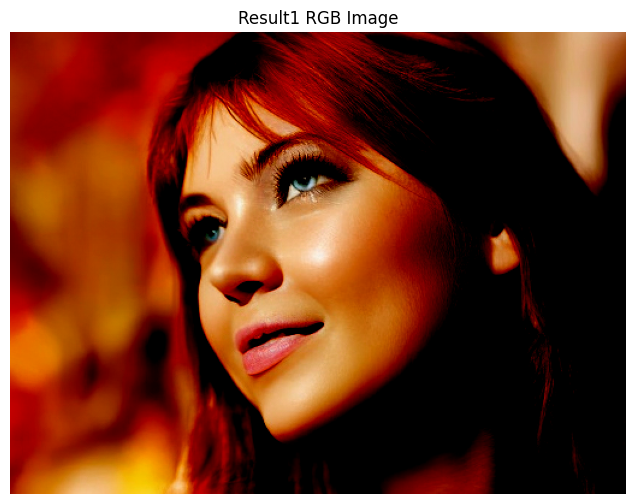

In [11]:
# Assuming result1_rgb is the tensor with shape [3, 384, 512]
result1_rgb = global_state.first_result[0]  # Shape: [3, 384, 512]

# Permute dimensions to [384, 512, 3] for plotting
result1_rgb = result1_rgb.permute(1, 2, 0)

# # Normalize the pixel values if necessary
# if result1_rgb.max() > 1.0:  # If the range is [0, 255]
#     result1_rgb = result1_rgb / 255.0  # Normalize to [0, 1]

# Plot as an RGB image
plt.figure(figsize=(10, 6))
plt.imshow(result1_rgb.cpu().numpy())  # Convert to NumPy for matplotlib
plt.axis('off')
plt.title("Result1 RGB Image")
plt.show()

In [14]:
gen_img_list2, key_video_path2 = process2(*ips)

images to generate 231 222 10
1


/home/shubham/anaconda3/envs/rerender/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.71it/s]


11


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


21


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


31


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


41


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


51


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


61


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


71


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.65it/s]


81


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


91


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


101


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


111


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.58it/s]


121


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


131


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


141


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


151


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.45it/s]


161


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


171


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


181


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.53it/s]


191


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


201


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


211


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.61it/s]


221


Global seed set to 0


Data shape for DDIM sampling is (1, 4, 48, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.50it/s]


In [15]:
key_video_path2

'result/pexels-koolshooters-7322716/key.mp4'

,,,,
,,,,

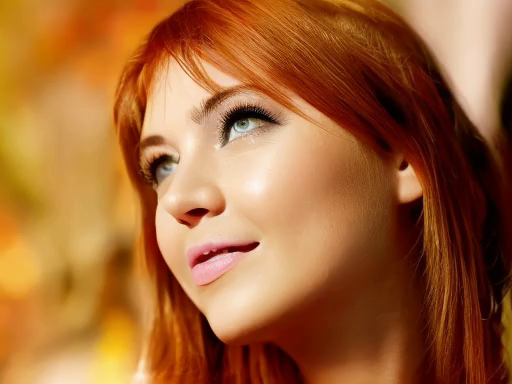
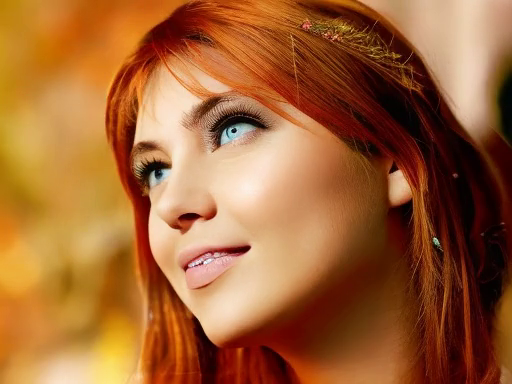
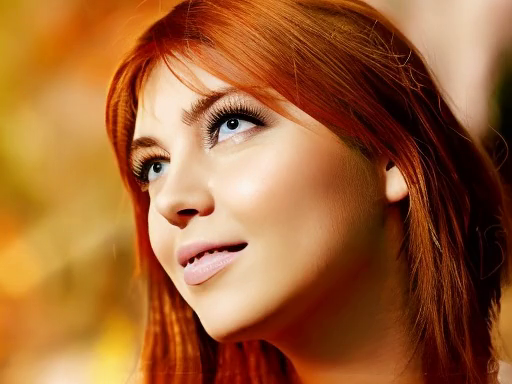
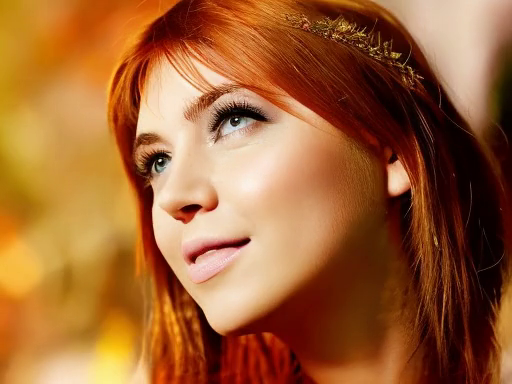
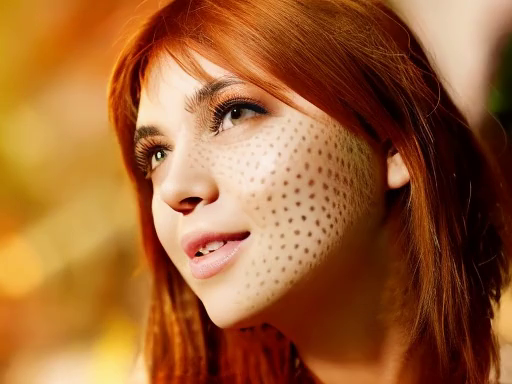
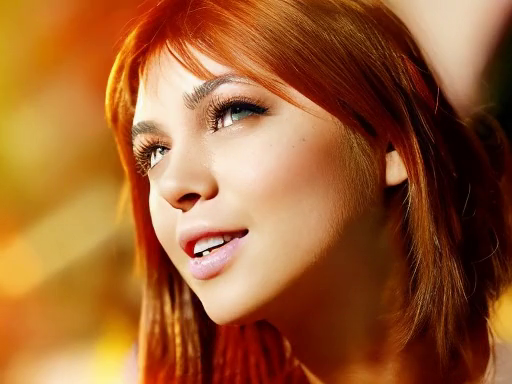
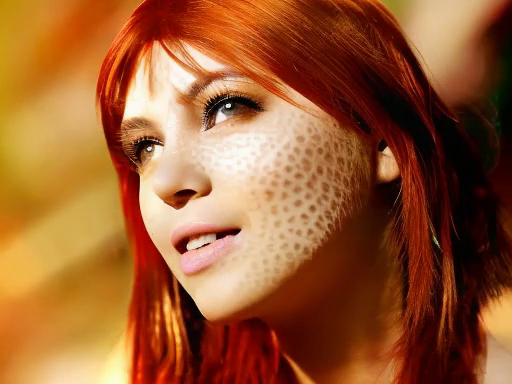
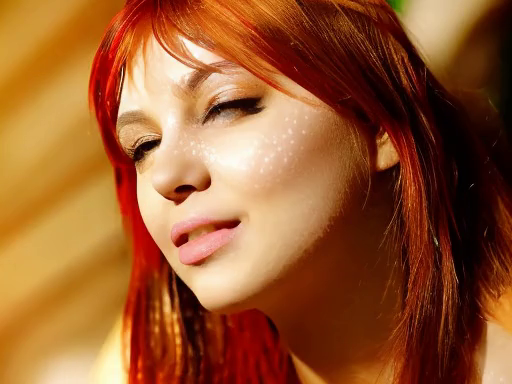
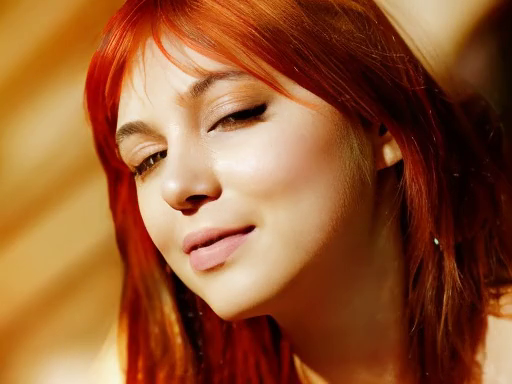
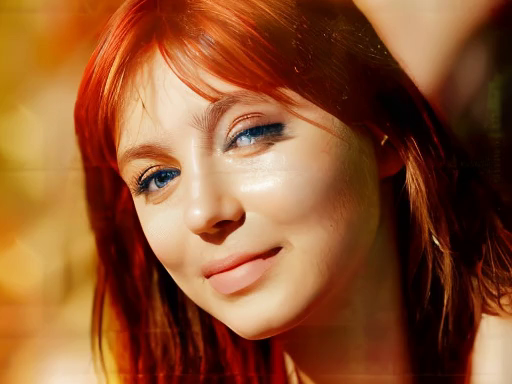

In [16]:
import torch
import cv2
import mediapy as media
import os

# Load the video
video_path = "result/pexels-koolshooters-7322716/key.mp4"  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Check if the video is opened successfully
if not cap.isOpened():
    raise ValueError("Error opening video file. Please check the path.")

# Extract frames and convert them to tensors
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Convert frame from BGR to RGB (as OpenCV uses BGR format by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert frame to tensor and append
    frame_tensor = torch.tensor(frame_rgb, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
    frames.append(frame_tensor)

cap.release()

# Plotting frames using mediapy
media.show_images([frame.permute(1, 2, 0).numpy().astype('uint8') for frame in frames[:10]], columns=5)  # Display first 10 frames


In [17]:
# Stack all frame tensors into a single tensor (Batch, Channels, Height, Width)
video_tensor = torch.stack(frames)  # Shape: (Num_Frames, Channels, Height, Width)

# Check the shape of the stacked tensor
print("Shape of video tensor:", video_tensor.shape)
torch.save(frames, "result/pexels-koolshooters-7322716/video_frames1.pt")  # Save as a PyTorch tensor file


Shape of video tensor: torch.Size([23, 3, 384, 512])


In [27]:
import sys
import numpy
import cv2

print("Python executable:", sys.executable)
print("Python paths:", sys.path)
print("NumPy version:", numpy.__version__)
print("NumPy location:", numpy.__file__)
print("OpenCV version:", cv2.__version__)


Python executable: /home/shubham/anaconda3/envs/rerender/bin/python
Python paths: ['/home/shubham/code/genAI/genaiProject/Rerender_A_Video/deps/gmflow', '/home/shubham/code/genAI/genaiProject/Rerender_A_Video/deps/ControlNet', '/home/shubham/code/genAI/genaiProject/Rerender_A_Video/deps/gmflow', '/home/shubham/anaconda3/envs/rerender/lib/python38.zip', '/home/shubham/anaconda3/envs/rerender/lib/python3.8', '/home/shubham/anaconda3/envs/rerender/lib/python3.8/lib-dynload', '', '/home/shubham/.local/lib/python3.8/site-packages', '/home/shubham/anaconda3/envs/rerender/lib/python3.8/site-packages', '/home/shubham/anaconda3/envs/rerender/lib/python3.8/site-packages/setuptools/_vendor', '/tmp/tmpbjo0xelq']
NumPy version: 1.23.0
NumPy location: /home/shubham/anaconda3/envs/rerender/lib/python3.8/site-packages/numpy/__init__.py
OpenCV version: 4.5.5


In [26]:
process3(*ips_process3)

/home/shubham/anaconda3/envs/rerender/bin python video_blend.py result/pexels-koolshooters-7322716 --beg 1 --end 221 --itv 10 --key keys  --output result/pexels-koolshooters-7322716/blend.mp4 --fps 25.0 --n_proc 4 -ps


sh: 1: /home/shubham/anaconda3/envs/rerender/bin: Permission denied


'result/pexels-koolshooters-7322716/blend.mp4'

In [ ]:
import cv2
import numpy as np

# Create a black image using NumPy
black_image = np.zeros((100, 100, 3), dtype=np.uint8)

# Display the image using OpenCV
cv2.imshow("Test Image", black_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [2]:
import numpy as np
array = np.zeros((3, 3))
print(array)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
import numpy as np
import cv2

# Create a blank 100x100 image with 3 color channels (RGB)
image = np.zeros((100, 100, 3), dtype=np.uint8)

# Draw a blue circle at the center of the image using OpenCV
cv2.circle(image, (50, 50), 20, (255, 0, 0), -1)

# Print versions
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

# Display the image in a window
cv2.imshow("Test Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [3]:
import numpy as np
import cv2

# Print versions
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

NumPy version: 1.23.0
OpenCV version: 4.5.5


In [18]:
import numpy

In [14]:
first_frame, key_frames, final_video = process(*ips)
print(f"First Frame: {first_frame}")
print(f"Key Frames: {key_frames}")
print(f"Final Video: {final_video}")

TypeError: create_cfg() missing 2 required positional arguments: 's1' and 's2'

In [34]:
print(global_state)

In [10]:
print(vars(global_state))

{'sd_model': 'Stable Diffusion 1.5', 'ddim_v_sampler': <src.ddim_v_hacked.DDIMVSampler object at 0x7f9a2c178160>, 'detector_type': None, 'detector': <deps.ControlNet.annotator.hed.HEDdetector object at 0x7f9a4d003250>, 'controller': <src.controller.AttentionControl object at 0x7f9a2c1783d0>, 'processing_state': <ProcessingState.KEY_IMGS: 2>, 'flow_model': GMFlow(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (

In [44]:
global_state.first_result.shape

torch.Size([1, 3, 384, 512])